In [2]:
from datetime import timedelta
import math
import os
import sys
sys.path.insert(0,'../src/')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import seaborn as sns
from preprocess import get_settings, get_combined_data
from citylearn.cost_function import CostFunction

In [3]:
SETTINGS = get_settings()
print(SETTINGS)

NEIGHBORHOOD_DIRECTORIES = [os.path.join(SETTINGS['neighborhood_directory'], d) for d in os.listdir(SETTINGS['neighborhood_directory']) if d.endswith('hood')]
print(NEIGHBORHOOD_DIRECTORIES)
NEIGHBORHOOD_NAMES = [d.split('_')[0:2] for d in os.listdir(SETTINGS['neighborhood_directory']) if d.endswith('hood')]
NEIGHBORHOOD_NAMES = [n[0].upper() + ', ' + n[1].capitalize() + ' County' for n in NEIGHBORHOOD_NAMES]
print(NEIGHBORHOOD_NAMES)
SIMULATION_IDS = [n.split(' ')[1].lower() for n in NEIGHBORHOOD_NAMES]
SIMULATION_OUTPUT_DIRECTORIES = [os.path.join(SETTINGS['simulation_output_directory'], i) for i in SIMULATION_IDS]
print(SIMULATION_OUTPUT_DIRECTORIES)
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
COST_FUNCTION_LABELS = {
    'electricity_consumption': 'Electricity consumption', 
    'price': r'$C$', 
    'carbon_emission': r'$G$',
    'zero_net_energy': r'$Z$',
    'average_daily_peak': 'Average daily peak',
    'peak_demand': 'Peak demand',
    'ramping': 'Ramping',
    '1 - load_factor': '1 - load factor',
}
NEIGHBORHOOD_NAMES = {
    'travis': 'Travis Co., TX',
}
ENVIRONMENT_DATA = get_combined_data('environment')
KPI_DATA = get_combined_data('kpi')
REWARD_DATA = get_combined_data('reward')

{'central_agent': False, 'episodes': 15, 'start_timestamp': '2018-01-01 00:00:00', 'end_timestamp': '2018-12-31 23:00:00', 'season_timestamps': {'winter': {'train_start_timestamp': '2018-01-01 00:00:00', 'train_end_timestamp': '2018-02-28 23:00:00', 'test_start_timestamp': '2018-03-01 00:00:00', 'test_end_timestamp': '2018-03-31 23:00:00'}, 'summer': {'train_start_timestamp': '2018-06-01 00:00:00', 'train_end_timestamp': '2018-07-31 23:00:00', 'test_start_timestamp': '2018-08-01 00:00:00', 'test_end_timestamp': '2018-08-31 23:00:00'}}, 'active_observations': ['day_type', 'hour', 'outdoor_dry_bulb_temperature', 'outdoor_dry_bulb_temperature_predicted_6h', 'outdoor_dry_bulb_temperature_predicted_12h', 'direct_solar_irradiance', 'direct_solar_irradiance_predicted_6h', 'direct_solar_irradiance_predicted_12h', 'non_shiftable_load', 'solar_generation', 'dhw_storage_soc', 'electrical_storage_soc', 'net_electricity_consumption'], 'active_actions': ['dhw_storage', 'electrical_storage'], 'sam_mo

# Sanity Checks
***

### Building KPIS

In [4]:
for n, n_data in KPI_DATA.groupby('neighborhood'):
    n_data = n_data[(n_data['level']=='district')].dropna()
    kpis = n_data['cost_function'].dropna().unique()
    buildings = n_data['resstock_bldg_id'].unique()
    row_count, column_count = len(buildings), len(kpis)
    fig, _ = plt.subplots(row_count, column_count, figsize=(column_count*3, 2*row_count))

    for ax, ((b, k), k_data) in zip(fig.axes, n_data.groupby(['resstock_bldg_id', 'cost_function'])):
        x, y = k_data['episode'], k_data['value']
        ax.plot(x, y)
        ax.axhline(1.0, color='black', linestyle='--')
        ax.set_title(f'{b}-{k}')

    plt.tight_layout()
    filename = f'{n}_building_training_kpis.pdf'
    plt.savefig(os.path.join(SETTINGS['figures_directory'], filename), bbox_inches='tight', transparent=True)
    plt.close()

- Travis is suspiciously too good to be true with electricity consumption reducing by 50% compared to without storage. Load factor on the other hand gets worse when the switch from RBC to RL is made but is on downward trajectory so it's improving. Other KPIs improve immediately the switch is made. Generally, 5 training episodes is sufficient.

- Chittenden seems to be unstable in its learning as load factor improves for the first 6 episodes even better than baseline but then starts worsening and is headed to the a similar performance as the baseline. Electricity consumption is the opposite as it gets worse then begins to improve. Seems like there is an indirect relationship between the two. Why? Zero-net energy looks like electricity consumption while other KPIs are stable. 10 training episodes is not sufficient for this location to make any conclusions.

- Alameda has stable learning and all KPIs except ZNE are improved by RL. Peak demand is sort of worsening though beyond the 6th episode. Do not think 10 episodes is sufficient for training.

### Building rewards

In [5]:
column_count_limit = 8

for n, r_data in REWARD_DATA.groupby('neighborhood'):
    r_data = r_data[r_data['mode']=='train'].copy()
    r_data = r_data.groupby(['resstock_bldg_id', 'episode'])[['reward']].sum().reset_index()
    buildings = r_data['resstock_bldg_id'].unique()
    row_count = math.ceil(len(buildings)/column_count_limit)
    column_count = min(column_count_limit, len(buildings))
    fig, _ = plt.subplots(row_count, column_count, figsize=(5*column_count, 2*row_count))

    for ax, (b, b_data) in zip(fig.axes, r_data.groupby('resstock_bldg_id')):
        x, y = b_data['episode'], b_data['reward']
        ax.plot(x, y)
        ax.set_title(b)

    plt.tight_layout()
    filename = f'{n}_reward_profiles.pdf'
    plt.savefig(os.path.join(SETTINGS['figures_directory'], filename), bbox_inches='tight', transparent=True)
    plt.close()

- The reward trajectory for Travis buildings is stable and as observed, 5 training episodes is sufficient.
- The reward trajectory for Chittenden is terribly unstable; it improves and worsens for some buildings. Will probably just leave this location out of the analysis.
- Alameda reward trajectory is also stable but might need more than 10 episodes for all buildings agents to converge. I think 15 episodes will be sufficient.

### Last 2-week in test period electricity consumption profile

In [6]:
column_count_limit = 6

for n, e_data in ENVIRONMENT_DATA.groupby('neighborhood'):
    ref_timestamp = e_data['timestamp'].max() - timedelta(days=14)
    e_data = e_data[
        (e_data['episode']==e_data['episode'].max())
        &(e_data['timestamp'] >= ref_timestamp)
    ].dropna().copy()
    buildings = sorted(e_data['resstock_bldg_id'].dropna().unique())
    row_count = math.ceil(len(buildings)/column_count_limit)
    column_count = min(column_count_limit, len(buildings))
    fig, _ = plt.subplots(row_count, column_count, figsize=(5*column_count, 2*row_count))

    for ax, (b, b_data) in zip(fig.axes, e_data.groupby('resstock_bldg_id')):
        b_data = b_data.reset_index()
        x = b_data['timestamp']
        
        y1 = b_data['net_electricity_consumption_without_storage_and_pv']
        y2 = b_data['net_electricity_consumption_without_storage'] 
        y3 = b_data['net_electricity_consumption']
        # ax.plot(x, y1, color='tab:red')
        ax.plot(x, y2, color='tab:blue')
        ax.plot(x, y3, color='tab:green')
        ax.xaxis.set_major_locator(mdates.HourLocator(0))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
        ax.set_title(b)

    plt.tight_layout()
    filename = f'{n}_2week_electricity_consumption_profiles.pdf'
    plt.savefig(os.path.join(SETTINGS['figures_directory'], filename), bbox_inches='tight', transparent=True)
    plt.close()

### Last 2-week in test period SoC

In [7]:
column_count_limit = 6

for n, e_data in ENVIRONMENT_DATA.groupby('neighborhood'):
    ref_timestamp = e_data['timestamp'].max() - timedelta(days=14)
    e_data = e_data[
        (e_data['episode']==e_data['episode'].max())
        &(e_data['timestamp'] >= ref_timestamp)
    ].dropna().copy()
    buildings = sorted(e_data['resstock_bldg_id'].dropna().unique())
    row_count = math.ceil(len(buildings)/column_count_limit)
    column_count = min(column_count_limit, len(buildings))
    fig, _ = plt.subplots(row_count, column_count, figsize=(5*column_count, 2*row_count))

    for ax, (b, b_data) in zip(fig.axes, e_data.groupby('resstock_bldg_id')):
        b_data = b_data.reset_index()
        x = b_data['timestamp']
        
        y1 = b_data['electrical_storage_soc']
        y2 = b_data['dhw_storage_soc']
        ax.plot(x, y1, color='tab:green')
        ax.plot(x, y2, color='tab:red')
        ax.xaxis.set_major_locator(mdates.HourLocator(0))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
        ax.set_title(b)

    plt.tight_layout()
    filename = f'{n}_2week_soc_profiles.pdf'
    plt.savefig(os.path.join(SETTINGS['figures_directory'], filename), bbox_inches='tight', transparent=True)
    plt.close()

### Average electricity consumption profile

In [8]:
column_count_limit = 6

for n, e_data in ENVIRONMENT_DATA.groupby('neighborhood'):
    ref_timestamp = e_data['timestamp'].max() - timedelta(days=14)
    e_data = e_data[
        (e_data['episode']==e_data['episode'].max())
        &(e_data['timestamp'] >= ref_timestamp)
    ].dropna().copy()
    e_data = e_data.groupby(['resstock_bldg_id', 'episode', 'day_of_week', 'hour'])[[
        'net_electricity_consumption', 
        'net_electricity_consumption_without_storage',
        'net_electricity_consumption_without_storage_and_pv'
    ]].mean().reset_index()
    buildings = sorted(e_data['resstock_bldg_id'].dropna().unique())
    row_count = math.ceil(len(buildings)/column_count_limit)
    column_count = min(column_count_limit, len(buildings))
    fig, _ = plt.subplots(row_count, column_count, figsize=(5*column_count, 2*row_count))

    for ax, (b, b_data) in zip(fig.axes, e_data.groupby('resstock_bldg_id')):
        b_data = b_data.reset_index()
        x = b_data.index
        y1 = b_data['net_electricity_consumption_without_storage_and_pv']
        y2 = b_data['net_electricity_consumption_without_storage'] 
        y3 = b_data['net_electricity_consumption']
        # ax.plot(x, y1, color='tab:red')
        ax.plot(x, y2, color='tab:blue')
        ax.plot(x, y3, color='tab:green')
        ax.set_title(b)

    plt.tight_layout()
    filename = f'{n}_average_electricity_consumption_profiles.pdf'
    plt.savefig(os.path.join(SETTINGS['figures_directory'], filename), bbox_inches='tight', transparent=True)
    plt.close()

- The PV is oversized-ish for Travis simulation because it is the summer and there is just plenty of sunlight to drastically reduce electricity consumption. The solar generation during the summer is much larger than the actual load! Which is why for the other locations that are simulated during the winter, the reduction in electricity consumption is not as much.
- The profiles don't have an issue in any of the locations just the PV is doing a lot of heavy lifting in the winter to assist by it overgenerating in the summer.
- A way to balance the result is to either simulate the entire year or simulate winter and summer separately for each location.

### Daily load area profile

In [9]:
column_count_limit = 8
loads = {
    'energy_from_electrical_storage': 'tab:brown',
    'energy_from_dhw_storage': 'grey',
    'energy_from_dhw_device': 'tab:orange',
    'energy_from_heating_device': 'tab:red',
    'energy_from_cooling_device': 'tab:blue',
    'energy_to_electrical_storage': 'purple',
    'energy_from_dhw_device_to_dhw_storage': 'aqua',
}


for n, e_data in ENVIRONMENT_DATA.groupby('neighborhood'):
    ref_timestamp = e_data['timestamp'].max() - timedelta(days=14)
    e_data = e_data[
        (e_data['episode']==e_data['episode'].max())
        &(e_data['timestamp'] >= ref_timestamp)
    ].dropna().copy()
    buildings = sorted(e_data['resstock_bldg_id'].dropna().unique())
    row_count = math.ceil(len(buildings)/column_count_limit)
    column_count = min(column_count_limit, len(buildings))
    fig, _ = plt.subplots(row_count, column_count, figsize=(5*column_count, 2*row_count))

    for ax, (b, b_data) in zip(fig.axes, e_data.groupby('resstock_bldg_id')):
        b_data = b_data.reset_index()
        x = b_data['timestamp']
        y = tuple([b_data[l].tolist() for l in loads])
        ax.stackplot(x,y,baseline='zero',labels=loads, colors=list(loads.values()))
        ax.xaxis.set_major_locator(mdates.HourLocator(0))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
        ax.set_title(b)

    plt.tight_layout()
    filename = f'{n}_load_area_profiles.pdf'
    plt.savefig(os.path.join(SETTINGS['figures_directory'], filename), bbox_inches='tight', transparent=True)
    plt.close()

# Paper Figures
***

### Building electricity consumption distribution

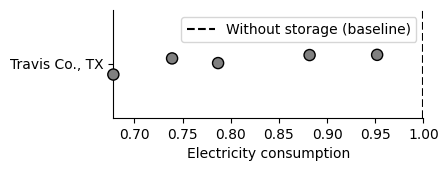

In [10]:
plot_data = KPI_DATA[
    (KPI_DATA['level']=='building')
    & (KPI_DATA['mode']=='test')
    & (KPI_DATA['cost_function']=='electricity_consumption')
].copy()
plot_data['neighborhood'] = plot_data['neighborhood'].map(lambda x: NEIGHBORHOOD_NAMES[x])
row_count, column_count = 1, 1
fig, ax = plt.subplots(row_count, column_count, figsize=(4*column_count, 1.4*row_count))
hue_order = sorted(plot_data['neighborhood'].unique().tolist())
sns.stripplot(y='neighborhood', x='value', data=plot_data, ax=ax, size=8, order=hue_order, color='grey', edgecolor='black', jitter=True, linewidth=1, clip_on=False)
ax.axvline(1.0, color='black', linestyle='--', label='Without storage (baseline)')
ax.set_xlabel(COST_FUNCTION_LABELS['electricity_consumption'])
ax.set_ylabel(None)

for s in ['top', 'right']:
    ax.spines[s].set_visible(False)

ax.legend()

filename = f'neighborhood_electricity_consumption_kpi_distribution.pdf'
plt.savefig(os.path.join(SETTINGS['figures_directory'], filename), bbox_inches='tight', transparent=True)
plt.show()

### District Level KPIs

neighborhood
Travis Co., TX    0.071576
Name: value, dtype: float64

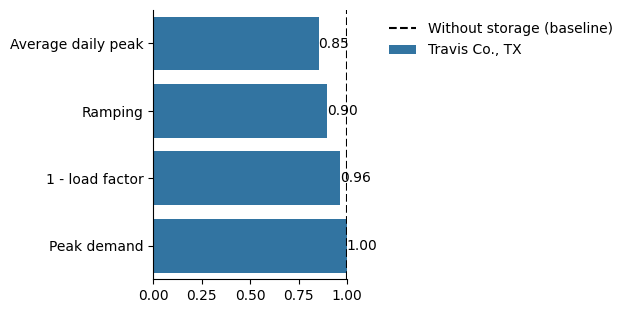

In [11]:
plot_data = ENVIRONMENT_DATA[ENVIRONMENT_DATA['mode']=='test'].copy()
plot_data = plot_data.groupby(['neighborhood', 'timestamp'])[['net_electricity_consumption', 'net_electricity_consumption_without_storage']].sum().reset_index()
kpi_data_list = []

for n, n_data in plot_data.groupby('neighborhood'):
    net_electricity_consumption = n_data['net_electricity_consumption']
    net_electricity_consumption_without_storage = n_data['net_electricity_consumption_without_storage']
    electricity_consumption_kpi = KPI_DATA[
        (KPI_DATA['neighborhood']==n) 
        & (KPI_DATA['level']=='building')
        & (KPI_DATA['mode']=='test')
        & (KPI_DATA['cost_function']=='electricity_consumption')
    ]['value'].mean()
    kpis = pd.DataFrame([{
    'cost_function': COST_FUNCTION_LABELS['ramping'],
    'value': CostFunction.ramping(net_electricity_consumption)[-1]/\
        CostFunction.ramping(net_electricity_consumption_without_storage)[-1],
    }, {
    'cost_function': COST_FUNCTION_LABELS['1 - load_factor'],
    'value': CostFunction.load_factor(net_electricity_consumption)[-1]/\
        CostFunction.load_factor(net_electricity_consumption_without_storage)[-1],
    },{
    # 'cost_function': COST_FUNCTION_LABELS['electricity_consumption'],
    # 'value': electricity_consumption_kpi,
    # }, {
    'cost_function': COST_FUNCTION_LABELS['average_daily_peak'],
    'value': CostFunction.average_daily_peak(net_electricity_consumption)[-1]/\
        CostFunction.average_daily_peak(net_electricity_consumption_without_storage)[-1],
    }, {
    'cost_function': COST_FUNCTION_LABELS['peak_demand'],
    'value': CostFunction.peak_demand(net_electricity_consumption)[-1]/\
        CostFunction.peak_demand(net_electricity_consumption_without_storage)[-1],
    }])
    kpis['neighborhood'] = NEIGHBORHOOD_NAMES[n]
    kpi_data_list.append(kpis)

plot_data = pd.concat(kpi_data_list, ignore_index=True, sort=False)
display(1 - plot_data.groupby('neighborhood')['value'].mean())
plot_data = plot_data.sort_values('value')


# plot
row_count = 1
column_count = 1
fig, ax = plt.subplots(row_count, column_count, figsize=(column_count*2.5, row_count*3.5))
hue_order = sorted(plot_data['neighborhood'].unique().tolist())
sns.barplot(x='value', y='cost_function', data=plot_data, hue_order=hue_order, hue='neighborhood', ax=ax)
ax.axvline(1.0, color='black', linestyle='--', label='Without storage (baseline)')
ax.set_xlabel('Score')
ax.set_ylabel(None)

for s in ['right','top']:
    ax.spines[s].set_visible(False)

for p in ax.patches:
    ax.text(p.get_x() + p.get_width(), p.get_y() + p.get_height()/2.0, f'{p.get_width():0.2f}', ha='left', va='center')

ax.set_xlabel(None)
ax.legend(
    bbox_to_anchor=(1.15,1.0),
    loc='upper left',
    framealpha=0,
    ncol=1
)

filename = f'neighborhood_kpi_summary.pdf'
plt.savefig(os.path.join(SETTINGS['figures_directory'], filename), bbox_inches='tight', transparent=True)
plt.show()


### District net electricity profile compared to without storage option

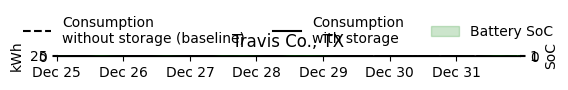

In [12]:
plot_data = ENVIRONMENT_DATA[ENVIRONMENT_DATA['mode']=='test'].groupby(['neighborhood', 'timestamp'])[['net_electricity_consumption', 'net_electricity_consumption_without_storage']].sum().reset_index()
soc_plot_data = ENVIRONMENT_DATA[ENVIRONMENT_DATA['mode']=='test'].groupby(['neighborhood', 'timestamp'])[[
    'dhw_storage_soc', 'electrical_storage_soc'
]].agg(['min', 'max', 'mean', 'std']).reset_index()
neighborhood_count = len(plot_data['neighborhood'].unique())
row_count, column_count = neighborhood_count, 1
fig, axs = plt.subplots(row_count, column_count, figsize=(column_count*6, row_count*1.75))

for i, (ax, (n, n_data), (_, s_data)) in enumerate(zip(fig.axes, plot_data.groupby('neighborhood'), soc_plot_data.groupby('neighborhood'))):
    ref_timestamp = n_data['timestamp'].max() - timedelta(days=6, hours=23)
    n_data = n_data[n_data['timestamp'] >= ref_timestamp].copy()
    s_data = s_data[s_data['timestamp'] >= ref_timestamp].copy()
    x = n_data['timestamp']
    y1 = n_data['net_electricity_consumption_without_storage']
    y2 = n_data['net_electricity_consumption']
    ax.plot(x, y1, color='black', linestyle='--', label='Consumption\nwithout storage (baseline)')
    ax.plot(x, y2, color='black', label='Consumption\nwith storage')
    ax.set_ylabel('kWh')
    ax.xaxis.set_major_locator(mdates.HourLocator(0))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax.set_title(NEIGHBORHOOD_NAMES[n])

    for s in ['right','top']:
        ax.spines[s].set_visible(False)

    ax2 = ax.twinx()
    y1 = s_data[('electrical_storage_soc', 'mean')] - s_data[('electrical_storage_soc', 'std')]
    y2 = s_data[('electrical_storage_soc', 'mean')] + s_data[('electrical_storage_soc', 'std')]
    y3 = s_data[('dhw_storage_soc', 'mean')] - s_data[('dhw_storage_soc', 'std')]
    y4 = s_data[('dhw_storage_soc', 'mean')] + s_data[('dhw_storage_soc', 'std')]
    ax2.fill_between(x, y1, y2, color='green', label='Battery SoC', alpha=0.2)
    # ax2.fill_between(x, y3, y4, color='green', label='DHW SoC', alpha=0.2)
    
    for s in ['left','top']:
        ax2.spines[s].set_visible(False)

    ax2.set_ylabel('SoC')
    ax2.set_ylim(0.0, 1.0)
    ax2.xaxis.set_major_locator(mdates.HourLocator(0))
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

    if i == row_count - 1:
        h1, l1 = ax.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        handles = h1 + h2
        labels = l1 + l2
        ax.legend(
            handles,
            labels,
            bbox_to_anchor=(0.5,-0.95),
            loc='lower center',
            framealpha=0,
            ncol=3
        )
    else:
        pass



plt.tight_layout()
fig.align_ylabels()
filename = f'neighborhood_electricity_consumption_profile_snapshot.pdf'
plt.savefig(os.path.join(SETTINGS['figures_directory'], filename), bbox_inches='tight', transparent=True)
plt.show()

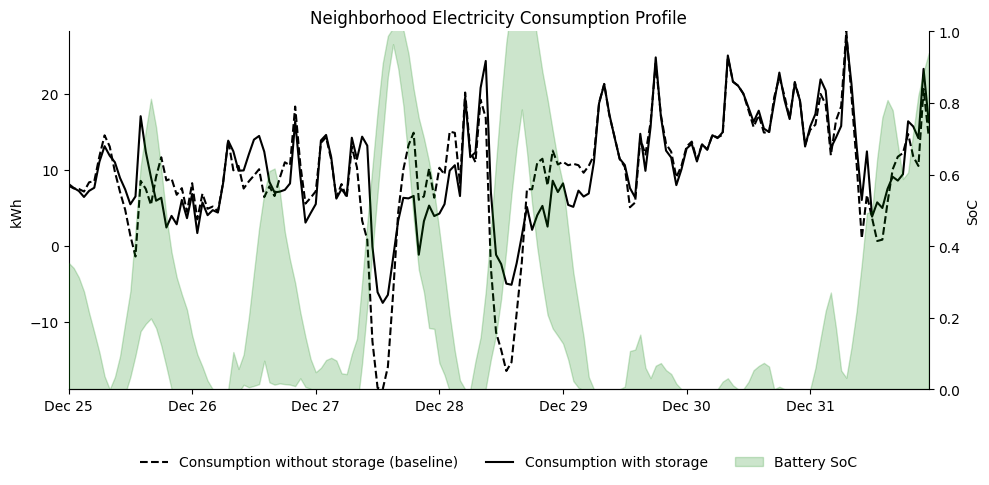

In [13]:
plot_data = ENVIRONMENT_DATA[ENVIRONMENT_DATA['mode']=='test'].groupby(['timestamp'])[['net_electricity_consumption', 'net_electricity_consumption_without_storage']].sum().reset_index()
soc_plot_data = ENVIRONMENT_DATA[ENVIRONMENT_DATA['mode']=='test'].groupby(['timestamp'])[[
    'dhw_storage_soc', 'electrical_storage_soc'
]].agg(['min', 'max', 'mean', 'std']).reset_index()

fig, ax = plt.subplots(figsize=(10, 5))

ref_timestamp = plot_data['timestamp'].max() - timedelta(days=6, hours=23)
plot_data = plot_data[plot_data['timestamp'] >= ref_timestamp].copy()
soc_plot_data = soc_plot_data[soc_plot_data['timestamp'] >= ref_timestamp].copy()

x = plot_data['timestamp']
y1 = plot_data['net_electricity_consumption_without_storage']
y2 = plot_data['net_electricity_consumption']
ax.plot(x, y1, color='black', linestyle='--', label='Consumption without storage (baseline)')
ax.plot(x, y2, color='black', label='Consumption with storage')
ax.set_ylabel('kWh')
ax.xaxis.set_major_locator(mdates.HourLocator(0))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.set_title('Neighborhood Electricity Consumption Profile')

for s in ['right', 'top']:
    ax.spines[s].set_visible(False)

ax2 = ax.twinx()
y1 = soc_plot_data[('electrical_storage_soc', 'mean')] - soc_plot_data[('electrical_storage_soc', 'std')]
y2 = soc_plot_data[('electrical_storage_soc', 'mean')] + soc_plot_data[('electrical_storage_soc', 'std')]
y3 = soc_plot_data[('dhw_storage_soc', 'mean')] - soc_plot_data[('dhw_storage_soc', 'std')]
y4 = soc_plot_data[('dhw_storage_soc', 'mean')] + soc_plot_data[('dhw_storage_soc', 'std')]
ax2.fill_between(x, y1, y2, color='green', label='Battery SoC', alpha=0.2)

for s in ['left', 'top']:
    ax2.spines[s].set_visible(False)

ax2.set_ylabel('SoC')
ax2.set_ylim(0.0, 1.0)
ax2.xaxis.set_major_locator(mdates.HourLocator(0))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
handles = h1 + h2
labels = l1 + l2
ax.legend(
    handles,
    labels,
    bbox_to_anchor=(0.5, -0.15),
    loc='upper center',
    framealpha=0,
    ncol=3
)

plt.tight_layout()
fig.align_ylabels()
filename = f'neighborhood_electricity_consumption_profile_snapshot.pdf'
plt.savefig(os.path.join(SETTINGS['figures_directory'], filename), bbox_inches='tight', transparent=True)
plt.show()



<AxesSubplot:label='bd1a2983-32da-4847-8278-5e1e536591ca', ylabel='SoC'>

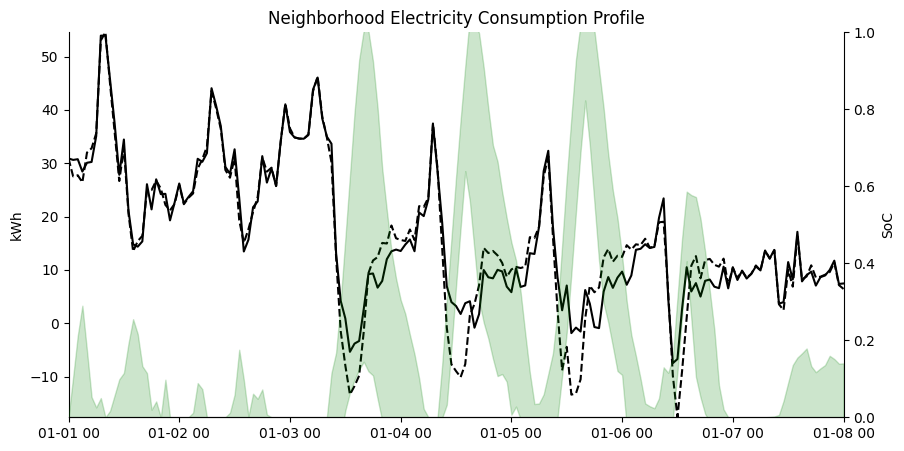

In [29]:
import datetime

plot_data = ENVIRONMENT_DATA[ENVIRONMENT_DATA['mode']=='test'].groupby(['timestamp'])[['net_electricity_consumption', 'net_electricity_consumption_without_storage']].sum().reset_index()
soc_plot_data = ENVIRONMENT_DATA[ENVIRONMENT_DATA['mode']=='test'].groupby(['timestamp'])[[
    'dhw_storage_soc', 'electrical_storage_soc'
]].agg(['min', 'max', 'mean', 'std']).reset_index()
   
fig, ax = plt.subplots(figsize=(10, 5))

ref_timestamp = plot_data['timestamp'].max() - timedelta(days=6, hours=23)

year = 2018
week_number = 1

# Calculate the first day of the specified week
start_of_week = datetime.datetime.strptime(f'{year}-W{week_number}-1', "%Y-W%W-%w")

# Set the end time to one week after the start of the week
end_of_week = start_of_week + datetime.timedelta(days=7)

plot_data = plot_data[(plot_data['timestamp'] >= start_of_week) & (plot_data['timestamp'] <= end_of_week)].copy()
soc_plot_data = soc_plot_data[(soc_plot_data['timestamp'] >= start_of_week) & (soc_plot_data['timestamp'] <= end_of_week)].copy()

x = plot_data['timestamp']
y1 = plot_data['net_electricity_consumption_without_storage']
y2 = plot_data['net_electricity_consumption']
ax.plot(x, y1, color='black', linestyle='--', label='Consumption without storage (baseline)')
ax.plot(x, y2, color='black', label='Consumption with storage')
ax.set_ylabel('kWh')
ax.xaxis.set_major_locator(mdates.HourLocator(0))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.set_title('Neighborhood Electricity Consumption Profile')

for s in ['right', 'top']:
    ax.spines[s].set_visible(False)

ax2 = ax.twinx()
y1 = soc_plot_data[('electrical_storage_soc', 'mean')] - soc_plot_data[('electrical_storage_soc', 'std')]
y2 = soc_plot_data[('electrical_storage_soc', 'mean')] + soc_plot_data[('electrical_storage_soc', 'std')]
y3 = soc_plot_data[('dhw_storage_soc', 'mean')] - soc_plot_data[('dhw_storage_soc', 'std')]
y4 = soc_plot_data[('dhw_storage_soc', 'mean')] + soc_plot_data[('dhw_storage_soc', 'std')]
ax2.fill_between(x, y1, y2, color='green', label='Battery SoC', alpha=0.2)

for s in ['left', 'top']:
    ax2.spines[s].set_visible(False)

ax2.set_ylabel('SoC')
ax2.set_ylim(0.0, 1.0)
ax2.xaxis.set_major_locator(mdates.HourLocator(0))
ax2
